# Title: CORRELATION MODEL IN THE ADOPTION OF E-PAYMENT SERVICES

## Load Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as ipw
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from plotly.subplots import make_subplots

from sklearn import svm, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, precision_recall_curve, roc_curve

import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr, kendalltau, pointbiserialr, chi2, chi2_contingency

from xgboost import XGBClassifier

%matplotlib inline

## Load Custom Made Libraries

In [2]:
from Utilities.CFS import *
from Utilities.reliefF import *
from Utilities.accuracy import *
from Utilities.corr_matrix import *
from Utilities.forward_selection import *
from Utilities.backward_elimination import *

from Visualization.model_graph import *
from Visualization.network_graph import *

from skfeature.utility.mutual_information import *

## Load Dataset

In [3]:
df = pd.read_csv("Dataset/E-payment Cryptocurrency Coin.csv")

## Label Binarizer

In [4]:
def convert_nominal(arr, term_arr):
    tmp_dict = {val:ind for (ind, val) in enumerate(term_arr)}
    return arr.map(lambda x : tmp_dict[x])

## Split Dataset

In [5]:
index_dict = {
    "Age": ["< 25 years", "26 - 40 years", "41 - 55 years", "above 55 years"],
    "Gender": ["Male", "Female"],
    "Marital Status": ["Single", "Married", "Other"],
    "Education Level": ['Primary school', 'Secondary/High school', 'College/university', 'Graduate school', 'Other'],
    "Work Industry": ['Banking / Finance', 'Education', 'Healthcare', 'Manufacturing', 'Retail / Hypermarket', 'Other'],
    "Work Position": ['Junior management', 'Middle management', 'Top management', 'Professional', 'Other']
}

In [6]:
mod_fac_df = pd.DataFrame()

column_arr = ["Age", "Gender", "Marital Status", "Education Level", "Work Industry", "Work Position"]

for (ind, col_name) in enumerate(column_arr):
    mod_fac_df[col_name] = df.iloc[:, 6 + ind]
    
# Replace Values in Work Industry
mod_fac_df = mod_fac_df.replace("Baking / Finance", "Banking / Finance")

# Label Binarize all columns
for col in column_arr:
    mod_fac_df[col] = convert_nominal(mod_fac_df[col], index_dict[col])

In [7]:
utaut_fac_df = pd.DataFrame()

column_arr = df.iloc[:, 28:].columns
column_arr = [col.split(": ")[0] for col in column_arr]

for (ind, col_name) in enumerate(column_arr):
    utaut_fac_df[col_name] = df.iloc[:, 28 + ind]
    utaut_fac_df[col_name] = utaut_fac_df[col_name].map(lambda x : x - 1)
    
# Change Data Type to int
utaut_fac_df = utaut_fac_df.astype(int)

In [8]:
tmp_mod_fac_df = pd.DataFrame()

column_arr = ["Age", "Gender", "Marital Status", "Education Level", "Work Industry", "Work Position"]

for (ind, col_name) in enumerate(column_arr):
    tmp_mod_fac_df[col_name] = df.iloc[:, 6 + ind]
    
tmp_mod_fac_df = tmp_mod_fac_df.replace("Baking / Finance", "Banking / Finance")

all_df_arr = [tmp_mod_fac_df, utaut_fac_df, df.iloc[:, [17, 18]]]

all_df = pd.concat(all_df_arr, axis = 1)
all_df.columns = all_df.columns.tolist()[:-2] + [col.split("[")[1][4:-1] for col in all_df.columns[-2:]]

In [9]:
arr_df = [mod_fac_df, utaut_fac_df.drop(["BI1", "BI2", "BI3", "BI4"], axis = 1)]

df_X = pd.concat(arr_df, axis = 1)
df_Y = all_df.loc[:, "BI3"]
    
# Change Data Type to int
df_X = df_X.astype(int)
df_Y = df_Y.astype(int)

## Analysis

#### Merit Based Ranking

![merit_based_ranking.jpg](img/merit_based_ranking.jpg)

In [10]:
arr_list = []

for col_ind in range(df_X.shape[1]):
    name = df_X.columns[col_ind]
    merit = merit_calculation(df_X.iloc[:, [col_ind]], df_Y, pointbiserialr)
    arr_list.append((col_ind ,name, merit))
    
# Sort Column By Merit Value
arr_list = sorted(arr_list, key = lambda x : x[2], reverse = True)

mbf_df = pd.DataFrame(arr_list, index = [i + 1 for i in range(len(arr_list))], columns = ["Rank" ,"Factors", "Merit"])

mbf_df["Rank"] = [ind + 1 for ind in range(mbf_df.shape[0])]

mbf_df.style.hide_index()

Rank,Factors,Merit
1,AT2,0.758455
2,PE1,0.754702
3,AT1,0.740729
4,PE4,0.738921
5,T4,0.728392
6,T2,0.721307
7,PE2,0.714664
8,EE2,0.703590
9,AT4,0.703217
10,PE3,0.702558


#### Correlation Pairwise Ranking

![correlation_pairwise_ranking.jpg](img/correlation_pairwise_ranking.jpg)

#### Pearson

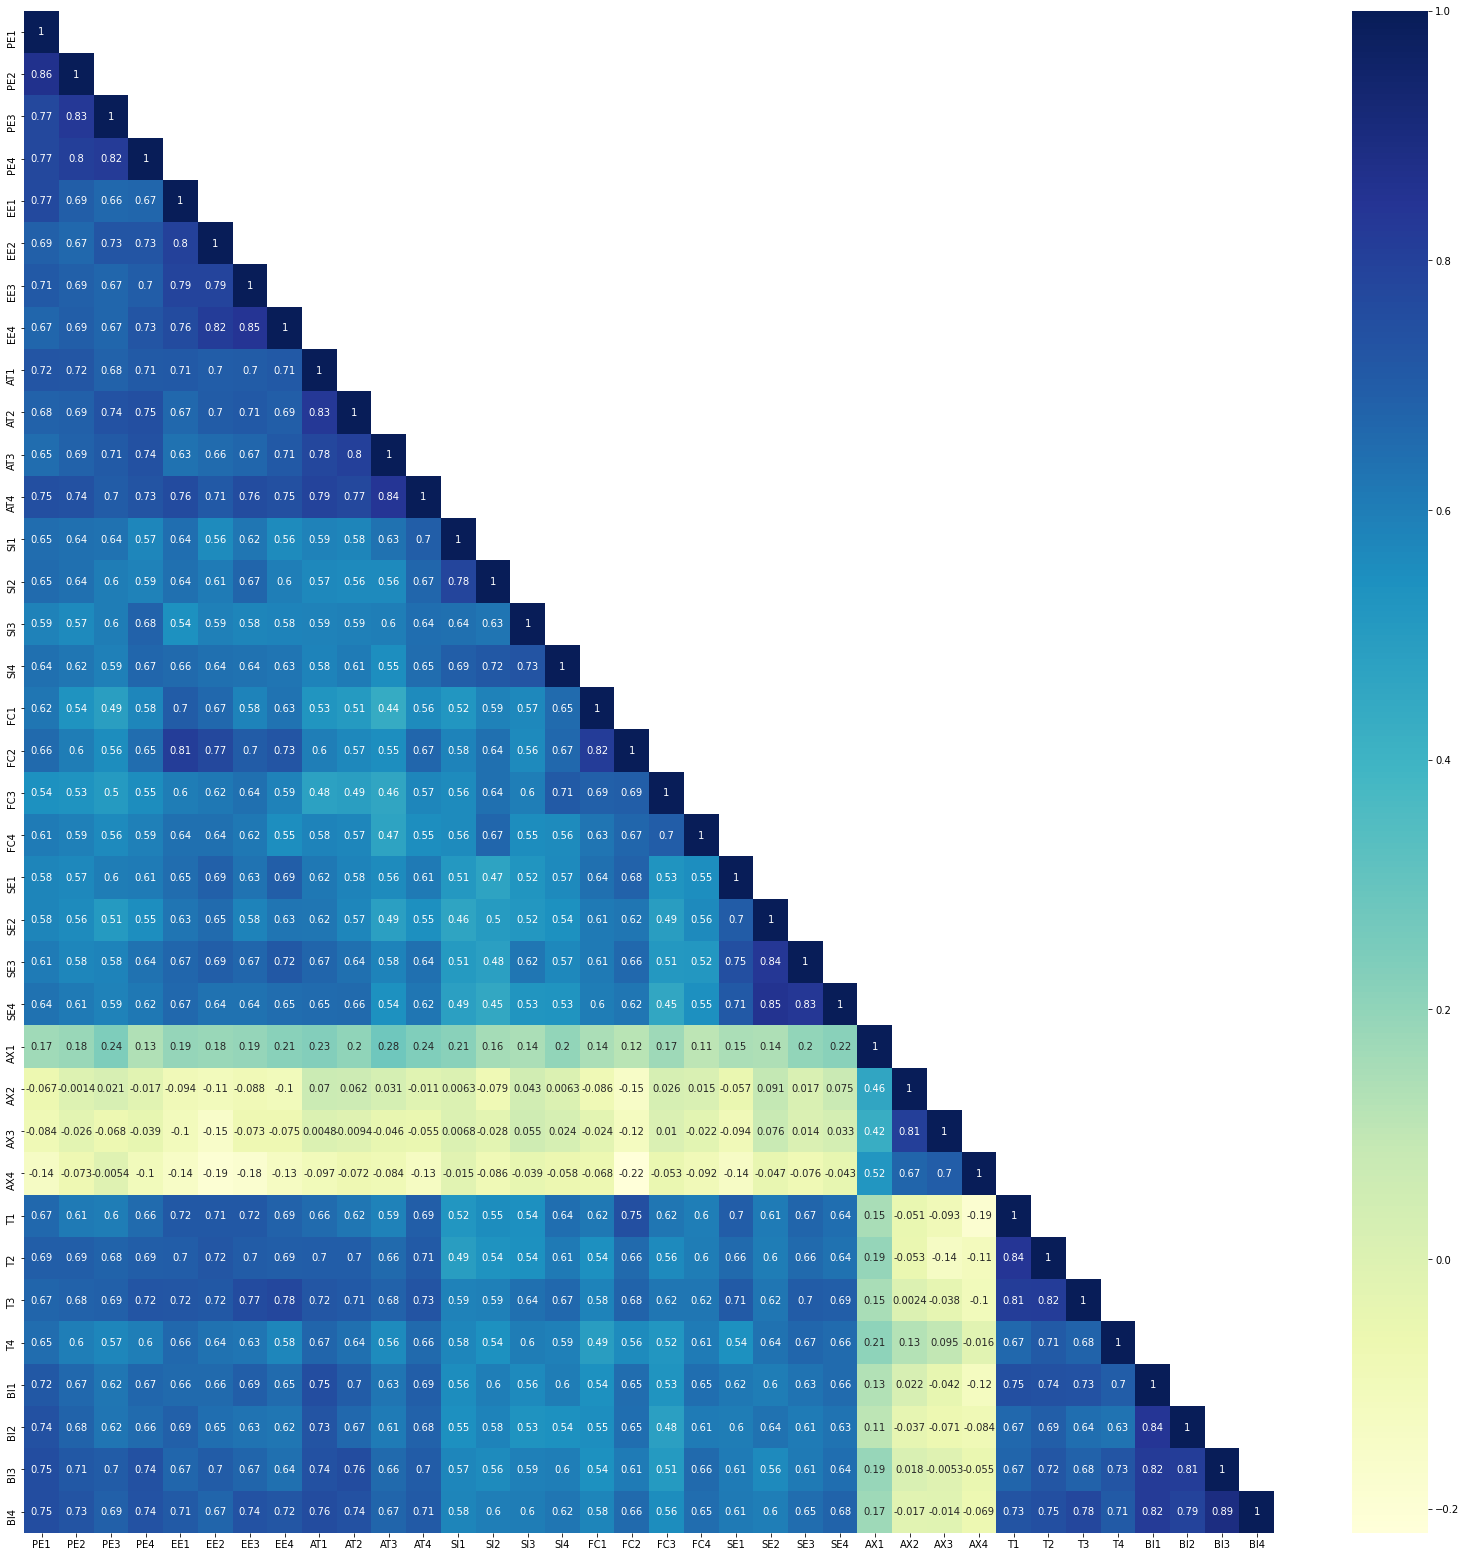

In [11]:
corr_df = create_corr_matrix(utaut_fac_df, pearsonr)

tmp_df = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))

fig = plt.figure(figsize=(28, 28))
sns.heatmap(tmp_df,annot=True,cmap='YlGnBu')
plt.show()

#### Spearman

In [12]:
corr_df = create_corr_matrix(utaut_fac_df, spearmanr)
corr_df = corr_df.abs()

upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape), k = 1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

to_drop

# fig = plt.figure(figsize=(28, 28))
# sns.heatmap(corr_df,annot=True,cmap='magma_r')
# plt.show()

['PE2', 'EE4', 'FC2', 'SE4', 'T2', 'BI2', 'BI3', 'BI4']

#### Correlation Based Ranking

![correlation_based_ranking.jpg](img/correlation_based_ranking.jpg)

In [13]:
arr_df = [mod_fac_df, utaut_fac_df.drop(["BI1", "BI2", "BI3", "BI4"], axis = 1)]

df_X = pd.concat(arr_df, axis = 1)
df_Y = all_df.loc[:, "BI3"]
    
# Change Data Type to int
df_X = df_X.astype(int)
df_Y = df_Y.astype(int)

In [14]:
func = spearmanr

arr_list = []

for col_ind in range(df_X.shape[1]):
    name = df_X.columns[col_ind]
    corr, p_val = func(df_X.iloc[:, col_ind], df_Y)
    arr_list.append((col_ind ,name, corr))
    
# Sort Column By Correlation Value
arr_list = sorted(arr_list, key = lambda x : x[2], reverse = True)

mbf_df = pd.DataFrame(arr_list, index = [i + 1 for i in range(len(arr_list))], columns = ["Rank" ,"Factors", "Weight For Ranking"])

mbf_df["Rank"] = [ind + 1 for ind in range(mbf_df.shape[0])]

mbf_df.style.hide_index()

Rank,Factors,Weight For Ranking
1,PE1,0.746661
2,PE4,0.727400
3,T4,0.722763
4,AT1,0.722441
5,PE2,0.715026
6,T2,0.712560
7,AT2,0.711945
8,T1,0.674247
9,PE3,0.669027
10,AT4,0.664287


## Network Graph

![correlation_based_network.jpg](img/correlation_based_network.jpg)

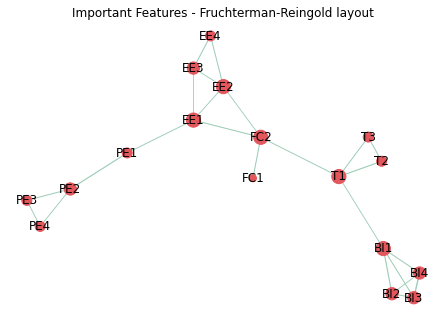

In [15]:
# Create Pairwise Correlation Matrix
corr_df = create_corr_matrix(utaut_fac_df, spearmanr)

Gx = create_graph(corr_df, 0.75)

# Get Edge Colours
edge_color = get_edge_color(Gx)

# Get Node Size
node_size = get_node_size(Gx, 50)

# Get Edge Width
edge_width = get_edge_width(Gx)

nx.draw(
    Gx,
    pos=nx.fruchterman_reingold_layout(Gx),
    with_labels=True,
    node_size=node_size,
    node_color="#e1575c",
    edge_color=edge_color,
    width = edge_width
)
plt.title("Important Features - Fruchterman-Reingold layout")
plt.show()

In [16]:
# Create Correlation Matrix
corr_df = create_corr_matrix(utaut_fac_df, spearmanr)

In [17]:
layout = dict(
    width = 500,
    height = 500,
    hovermode = "closest",
    plot_bgcolor = "#fff",
)

In [18]:
# Circular Layout
cirFig = network_graph(corr_df, "Important Features - Circular Layout", nx.circular_layout, 0.75)
cirFig.update_layout(layout)

# Fruchterman Layout
fruFig = network_graph(corr_df, "Important Features - Fruchterman Reingold Layout", nx.fruchterman_reingold_layout, 0.75)
fruFig.update_layout(layout)

ipw.HBox([go.FigureWidget(cirFig), go.FigureWidget(fruFig)])

    'data': [{'hoverinfo': 'none',
              'line': {'color': '#DCDCDC', 'w…

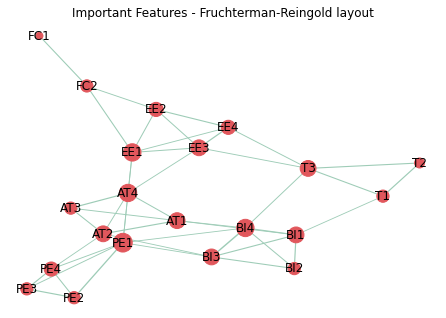

In [19]:
# Create Pairwise Correlation Matrix
corr_df = create_corr_matrix(utaut_fac_df, pearsonr)

Gx = create_graph(corr_df, 0.75)

# Get Edge Colours
edge_color = get_edge_color(Gx)

# Get Node Size
node_size = get_node_size(Gx, 50)

# Get Edge Width
edge_width = get_edge_width(Gx)

nx.draw(
    Gx,
    pos=nx.fruchterman_reingold_layout(Gx),
    with_labels=True,
    node_size=node_size,
    node_color="#e1575c",
    edge_color=edge_color,
    width = edge_width
)
plt.title("Important Features - Fruchterman-Reingold layout")
plt.show()

In [27]:
# Create Pairwise Correlation Matrix
corr_df = create_corr_matrix(utaut_fac_df, pearsonr)

In [28]:
# Circular Layout
cirFig = network_graph(corr_df, "Important Features - Circular Layout", nx.circular_layout, 0.75)
cirFig.update_layout(layout)

# Fruchterman Layout
fruFig = network_graph(corr_df, "Important Features - Fruchterman Reingold Layout", nx.fruchterman_reingold_layout, 0.75)
fruFig.update_layout(layout)

ipw.HBox([go.FigureWidget(cirFig), go.FigureWidget(fruFig)])

    'data': [{'hoverinfo': 'none',
              'line': {'color': '#DCDCDC', 'w…

## Weka Analysis

In [21]:
tmp_X = df_X
tmp_Y = df_Y

tmp_df = pd.DataFrame()

# Chi Square
chisq_arr = []

prob = 0.95

for col in tmp_X.columns:
    chi_df = pd.crosstab(tmp_X.loc[:, col], tmp_Y)
    stat, p, dof, expected = chi2_contingency(chi_df)
        
    chisq_arr.append(stat)

tmp_df["Chi-Square"] = chisq_arr
tmp_df["Chi-Square (Rank)"] = [*stats.rankdata(tmp_df["Chi-Square"] * -1).astype(int)]

# Information Gain
info_gain_arr = []

for col in tmp_X.columns:
    # Information Gain
    val = information_gain(tmp_X.loc[:, col], tmp_Y)
    info_gain_arr.append(val)
    
tmp_df["Info Gain"] = np.array(info_gain_arr)
tmp_df["Info Gain (Rank)"] = [*stats.rankdata(tmp_df["Info Gain"] * -1).astype(int)]

tmp_df.index = tmp_X.columns

tmp_df = tmp_df.sort_values("Chi-Square (Rank)")

tmp_df

,Chi-Square,Chi-Square (Rank),Info Gain,Info Gain (Rank)
T2,478.020449,1,0.810035,2
T4,462.458594,2,0.828603,1
AT2,449.286030,3,0.736678,4
AT1,438.627939,4,0.800913,3
T1,435.665374,5,0.728820,5
T3,423.444443,6,0.645822,13
PE4,399.616048,7,0.702910,7
EE1,397.486113,8,0.716019,6
EE3,395.812364,9,0.649588,10
PE1,387.102459,10,0.684139,8


## Graph Over Features Selection

In [22]:
# def cmp_n_feature_df(X, Y, model, func, s_num = 5, e_num = 16):
#     arr_list = []
    
#     for num in range(s_num, e_num):
#         feature_set = func(tmp_X, tmp_Y, model, num)
    
#         acc_score = get_acc_score_kcv(tmp_X, tmp_Y, model)
    
#         arr_list.append((num, feature_set, round(acc_score, 2)))
        
#     return pd.DataFrame(arr_list, columns = ["Number of Features", "Feature Set", "Accuracy Score"])

In [23]:
# tmp_X = df_X
# tmp_Y = df_Y

# model = DecisionTreeClassifier()

# arr_list = []

# for num in range(5,16):
#     feature_set = backward_selection(tmp_X, tmp_Y, model, num)
    
#     acc_score = get_acc_score_kcv(tmp_X, tmp_Y, model)
    
#     arr_list.append((num, feature_set, round(acc_score, 2)))
    
# tmp_df = pd.DataFrame(arr_list, columns = ["Number of Features", "Feature Set", "Accuracy Score"])
# tmp_df.style.hide_index()

In [24]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x = tmp_df["Number of Features"], y = tmp_df["Accuracy Score"]))
# fig.show()

## Probability Distribution Features

In [25]:
# def feature_prob_df(feature_set, ori_arr):
#     tmp_dict = {col:0 for col in ori_arr}
    
#     for feature_arr in feature_set:
#         for feature in feature_arr:
#             tmp_dict[feature] += 1
            
#     tmp_df = pd.DataFrame(pd.Series(tmp_dict), columns = ["Feature"])
#     tmp_df = tmp_df.sort_values(by = ["Feature"], ascending = False)
            
#     return tmp_df

In [26]:
# feature_set = tmp_df["Feature Set"]
# ori_arr = tmp_X.columns
        
# prob_df = feature_prob_df(feature_set, ori_arr)
# prob_df